In [1]:
using JUDI, PyPlot, DSP, SegyIO, JLD, SlimPlotting

In [2]:
block = segy_read("../data/sgy/marmousi_2D.segy")
d_obs = judiVector(block);

┌ Warning: Fixed length trace flag set in stream: IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=800038804, maxsize=Inf, ptr=3601, mark=-1)
└ @ SegyIO ~/.julia/packages/SegyIO/OfiKG/src/read/read_file.jl:36


## 00_Ploting Data Shot Record

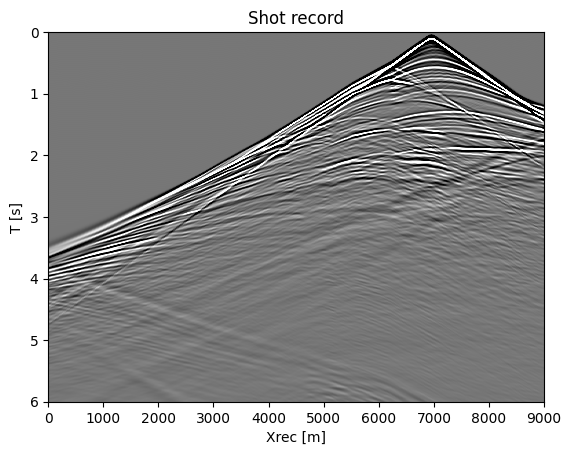

In [3]:
num_of_shot = 140
plot_sdata(d_obs.data[num_of_shot], (0.002, 25))

## 01_Plotting Frequency Spectrum

We define a function to extract the spectrum data, including both the magnitude of the sample and their corresponding frequencies, by implementing the FFT using DSP package.

In [ ]:
function extracted_mean_spectrum(shot_gather, fs)
    n_samples, n_traces = size(shot_gather)
    mean_spectrum = zeros(n_samples)
    for i in 1:n_traces
        spectrum = abs.(fft(shot_gather[:, i]))
        mean_spectrum .+= spectrum
    end
    mean_spectrum ./= n_traces
    freqs = DSP.fftfreq(n_samples, fs)
    # Separate positive frequencies
    pos_freqs = freqs[1:div(n_samples, 2)+1]

    return pos_freqs, mean_spectrum[1:div(n_samples, 2)+1]
end

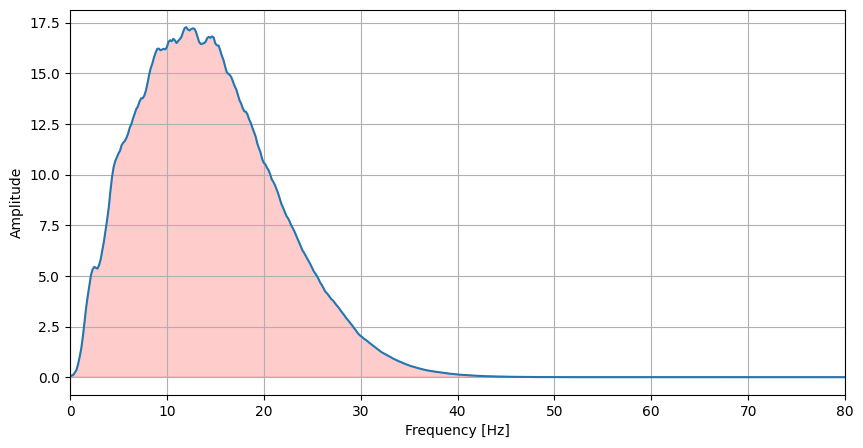

In [47]:
dt = d_obs.geometry.taxis[1].step * 1e-3  #sampling time in s
fs = 1 / dt #frequency of sample
shot_gather = d_obs.data[1];

figure(figsize=(10, 5))
grid()
pos_freqs, mean_spectrum = extracted_mean_spectrum(shot_gather, fs)
plot(pos_freqs, mean_spectrum)
fill_between(x=pos_freqs, y1=mean_spectrum, color= "r", alpha= 0.2)
id_max_amp = argmax(mean_spectrum)
# vlines(pos_freqs[id_max_amp], ymin=0,  ymax=mean_spectrum[id_max_amp])
xlim(0, 80)
xlabel("Frequency [Hz]")
ylabel("Amplitude");

We can see that, the maximum  or dominant frequency arround 12-15 Hz, which matches the source wavelet frequency arround 15 Hz.

## 02_Split the Dataset to Low Frequency and High Frequency

In [60]:
shot_gather_lpf = filtfilt(digitalfilter(Lowpass(5; fs=fs), FIRWindow(hanning(64))), shot_gather);
shot_gather_hpf = filtfilt(digitalfilter(Highpass(5; fs=fs), Butterworth(4)), shot_gather);

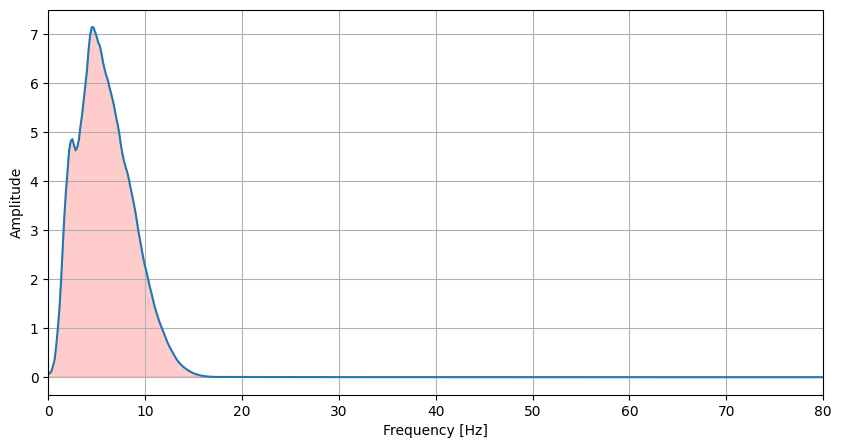

In [57]:
figure(figsize=(10, 5))
grid()
pos_freqs, mean_spectrum = extracted_mean_spectrum(shot_gather_lpf, fs)
plot(pos_freqs, mean_spectrum)
fill_between(x=pos_freqs, y1=mean_spectrum, color= "r", alpha= 0.2)
id_max_amp = argmax(mean_spectrum)
# vlines(pos_freqs[id_max_amp], ymin=0,  ymax=mean_spectrum[id_max_amp])
xlim(0, 80)
xlabel("Frequency [Hz]")
ylabel("Amplitude");

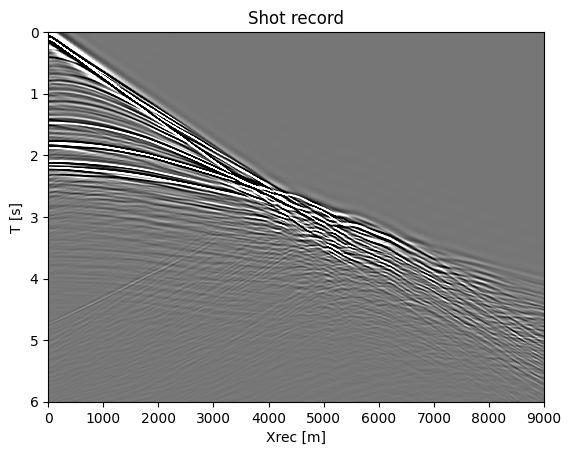

In [61]:
plot_sdata(shot_gather_hpf, (0.002, 25))